In [1]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import h5py
import numpy as np 


from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from PIL import Image

sns.set_context("talk")

%matplotlib inline

In [2]:
species_map={1:"$Fe_2^+$",2:"$Fe_3^+$",3:"O($Fe_3O_4$)",4:"O($H_2O$)",5:"H",6:"H2",7:"M"}

df_hist_list=list()
data_dict={}
for temperature in [200,300]:
    for molecules in [100,250,500,1000]:
        data_dict["../results/gromacs/nanoparticle/H2O/2nm/concentration/results/%d/rdh%dK/"%(molecules,temperature)]=(temperature,"LJ",molecules) 
        data_dict["../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/%d/rdh%dK/"%(molecules,temperature)]=(temperature,"ReaxFF2022",molecules)

df_hist_list=list()       
for basepath, (temperature,force_field,H2O_molecules) in data_dict.items():
    for filename in os.listdir(basepath):
        if not "hist" in filename:
            continue
        species=int(filename.split("_")[-1].replace(".csv",""))
        df_tmp=pd.read_csv(os.path.join(basepath,filename),skiprows=1,skipfooter=1, engine='python',names=["Distance (A)","count"]).query("count>0")
        df_tmp["Temperature (K)"]=temperature
        df_tmp["Force Field"]=force_field
        df_tmp["Species"]=species_map[species] 
        df_tmp["$H_2O$"]=H2O_molecules
        df_tmp["norm"]=df_tmp["count"]/df_tmp["count"].max()
        df_hist_list.append(df_tmp)
df_hist=pd.concat(df_hist_list,ignore_index=True)
df_hist

,Distance (A),count,Temperature (K),Force Field,Species,$H_2O$,norm
0,0.27825,6,200,LJ,$Fe_2^+$,100,0.000218
1,0.28175,28,200,LJ,$Fe_2^+$,100,0.001016
2,0.28525,114,200,LJ,$Fe_2^+$,100,0.004137
3,0.28875,306,200,LJ,$Fe_2^+$,100,0.011103
4,0.29225,942,200,LJ,$Fe_2^+$,100,0.034181
...,...,...,...,...,...,...,...
42862,3.48425,688,300,ReaxFF2022,H,1000,0.015843
42863,3.48775,675,300,ReaxFF2022,H,1000,0.015543
42864,3.49125,600,300,ReaxFF2022,H,1000,0.013816
42865,3.49475,627,300,ReaxFF2022,H,1000,0.014438


0
1


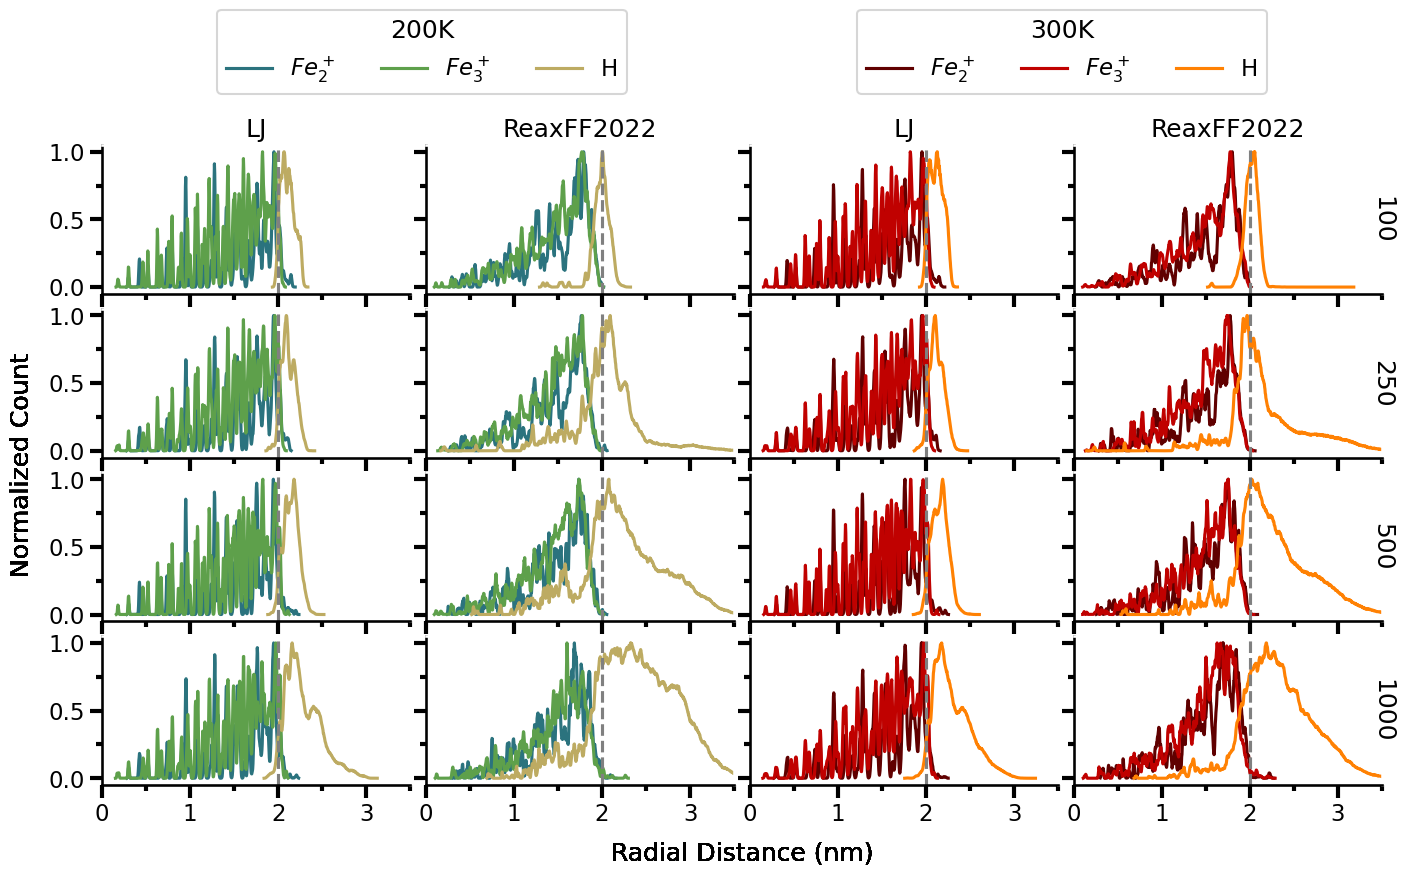

In [4]:
def func(x,  a, b,m):
    return a*np.exp(-b*(x-m)**2)



temperature_list=df_hist["Temperature (K)"].unique()
force_field_list=df_hist["Force Field"].unique()
H2O_molecules_list=df_hist["$H_2O$"].unique()

len_nrows=len(H2O_molecules_list)
len_ncols=len(force_field_list)+len(temperature_list)
fig, axs = plt.subplots(nrows=len_nrows,ncols=len_ncols,figsize=(4*len_ncols,2*len_nrows))
sns.set_context("talk")

labx=0.025
laby=0.95

index_label=list("abcd")
df_list=list()
for j, force_field in enumerate(force_field_list):
    for i, temperature in enumerate(temperature_list):
        for k, H2O_molecules in enumerate(H2O_molecules_list):
        
            ax=axs[k,j+len(temperature_list)*i]
            df_tmp=df_hist.query("`Temperature (K)` == %d and `Force Field` == '%s'  and `$H_2O$`==%d"%(temperature,force_field,H2O_molecules))

            sns.lineplot(data=df_tmp.query("Species == '$Fe_2^+$' or Species == '$Fe_3^+$' or Species == 'H'") 
                         ,x="Distance (A)"
                         ,y="norm"
                         ,hue="Species"
                         ,ax=ax
                         ,palette="gist_earth" if i ==0 else 'gist_heat'
                         ,legend=j+k==0 
                        )

            if i*j*k==0:
                ax.text(0.5, 0.0, 'Radial Distance (nm)' ,transform=fig.transFigure,ha="center",va="bottom")
                ax.text(0.05, 0.5, 'Normalized Count' ,transform=fig.transFigure,ha="center",va="center",rotation="vertical")
            if i+j == len(force_field_list)+len(temperature_list)-2:
                ax.text(1, 0.5, '%d'%H2O_molecules ,transform=ax.transAxes,ha="center",va="center",rotation=-90)
                
                
            ax.set_xlabel("")
            ax.set_ylabel("")
            if k != len(H2O_molecules_list)-1:
                ax.set_xticklabels([])
            if i+j != 0:
                ax.set_yticklabels([])
                
                
            if k==0:
                ax.set_title("%s"%(force_field))
                if j==0:
                    sns.move_legend(ax,'lower center',bbox_to_anchor=(0.3+i*0.4,0.95),ncol=4,bbox_transform=fig.transFigure,title='%dK'%temperature)
                    print(i)
#                    ax.text(1, 1.25, '%dK'%temperature ,transform=ax.transAxes,ha="right",va="bottom")

            ax.spines['bottom'].set_color('0')
            ax.spines['top'].set_color('1')
            ax.spines['right'].set_color('1')
            ax.spines['left'].set_color('0')
            ax.tick_params(direction='out', width=3, bottom=True, left=True)
            ax.grid(False)
            ax.axvline(x=2,ymin=0,ymax=1,c='gray',ls='--')
            ax.set_xlim(0,3.5)

            ax.xaxis.set_minor_locator(MultipleLocator(1/2))
            ax.yaxis.set_minor_locator(MultipleLocator(0.5/2))
            ax.tick_params(which='minor', length=4,width=3)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.1)
plt.savefig("../figures/figC3.pdf", pad_inches=0.2,bbox_inches="tight")